# Hosmer-Lemeshow test (HL test)

## Theoretical Background
The Hosmer-Lemeshow test (HL Test) is a statistical test that can be used to assess the calibration of a probabilistic model. The test works by dividing the predicted probabilities into groups (typically deciles) and comparing the observed and expected frequencies of events in each group. A non-significant p-value (usually greater than 0.05) indicates we cannot reject the hypothesis that the model is well-calibrated, while a significant p-value suggests the opposite. The Hosmer-Lemeshow test is widely used in the literature and industry since it is simple to implement and interpret.

In order to calculate the Hosmer-Lemeshow test statistic, we need to first determine the binning scheme used to divide the predicted probabilities into groups. Conventionally, the predicted probabilities are divided into 10 equal-width bins. We will label the equal-width binning Hosmer-Lemeshow test as HL-H and equal-count binning Hosmer-Lemeshow test as HL-C. The Hosmer-Lemeshow test statistic is then calculated as follows:

$$
\text{HL} = \sum_{m=1}^{M} \left[\frac{(O_{1,m}-E_{1,m})^2}{E_{1,m}} + \frac{(O_{0,m}-E_{0,m})^2}{E_{0,m}}\right]  = \sum_{m=1}^{M} \frac{(O_{1,m}-E_{1,m})^2}{E_{1,m}(1-\frac{E_{1,m}}{N_m})} \sim \chi^2_{M-2}
$$

where $E_{1,m}$ is the expected number of class 1 events in the $\text{m}^{th}$ bin, $O_{1,m}$ is the observed number of class 1 events in the $\text{m}^{th}$ bin, $N_m$ is the total number of observations in the $\text{m}^{th}$ bin, and $M$ is the number of bins. The HL test statistic is distributed as a chi-squared distribution with $M-2$ degrees of freedom. We can then use this test statistic to calculate the p-value for the test and determine whether we can reject the null hypothesis that the model is well-calibrated. Notice that the degree of freedom of HL test is $M-2$ by default but some literature suggests that the degree of freedom should be $M$ instead when the samples is not used for training. We provides the option to specify the degree of freedom in the `calzone`. The default value is still $M-2$.

## Pros of HL test

The Hosmer-Lemeshow test offers several advantages in assessing calibration. It is a non-parametric test, meaning it does not require any assumptions about the distribution of the predicted probabilities, and it provides statistical meaning to the resulting test statistic. It is also very intuitive and easy to understand since it is just a chi-square based test. It can be calculated from the result of the reliability diagram. The HL test is widely used in the literature as a validation method for model calibration.

## Cons of HL Test

Many studies have shown that the HL test is not an ideal way to examine the calibration of a model. The biggest problem is that the HL test depends on the binning scheme used. Whether equal-width or equal-count binning and the number of bins used can affect the results of the HL test. It is shown that the standard 10 equal-width bins often have the wrong size and low statistical power. Therefore, it is recommended not to use the HL test to examine the calibration of a model. However, the HL test is still a useful tool to quickly check the calibration of a model and provide a reference for the calibration of a model.

## Calculating HL test statistics and p-value with calzone

There are again two ways to calculate the HL test statistics and p-value with calzone. One is to call the function explicitly, and the other is to use the calzone.metrics.CalibrationMetrics class.

In [1]:
from calzone.utils import reliability_diagram,data_loader
from calzone.metrics import hosmer_lemeshow_test
import numpy as np

### loading the data
wellcal_dataloader = data_loader(data_path="../../../example_data/simulated_welldata.csv")

### calculating the HL-H TS
reliability,confindence,bin_edges,bin_counts = reliability_diagram(wellcal_dataloader.labels,wellcal_dataloader.probs,num_bins=10, class_to_plot=1, is_equal_freq=False)

HL_H_ts,HL_H_p,df = hosmer_lemeshow_test(reliability,confindence,bin_count=bin_counts)
print("HL-H Test Statistic: ",HL_H_ts)
print("HL-H p-value: ",HL_H_p)

HL-H Test Statistic:  8.884991559088098
HL-H p-value:  0.35209071874348785


In [2]:
### similar for HL-C model
reliability,confindence,bin_edges,bin_counts = reliability_diagram(wellcal_dataloader.labels,wellcal_dataloader.probs,num_bins=10, class_to_plot=1, is_equal_freq=True)

HL_C_ts,HL_C_p,df = hosmer_lemeshow_test(reliability,confindence,bin_count=bin_counts)
print("HL-C Test Statistic: ",HL_C_ts)
print("HL-C p-value: ",HL_C_p)

HL-C Test Statistic:  3.694947603203135
HL-C p-value:  0.8835446575708198


We can see the result from equal-width binning and equal-count binning are different. We will demostrate how to use the calzone.metrics.CalibrationMetrics class.

In [3]:
### using the CalibrationMetrics class
from calzone.metrics import CalibrationMetrics
calmetrics = CalibrationMetrics(class_to_calculate=1)
calmetrics.calculate_metrics(wellcal_dataloader.labels, wellcal_dataloader.probs, metrics=['HL-H', 'HL-C'])

{'HL-H score': 8.884991559088098,
 'HL-H p-value': 0.35209071874348785,
 'HL-C score': 3.694947603203135,
 'HL-C p-value': 0.8835446575708198}

## Size of HL test

We will show the size of HL test. Notice that the size of HL test had been shown to depend on sample size, number of bin and binning scheme (Hosmer et. al. 1997). We will generate fake data to show the size of HL test.

In [4]:
### The size of HL Test
from calzone.utils import fake_binary_data_generator
np.random.seed(123)
fakedata_generator = fake_binary_data_generator(alpha_val=0.5, beta_val=0.5)
cal_metrics = CalibrationMetrics()
sample_size = 1000
simulation_size = 10000
results = []
# generate data
for i in range(simulation_size):
    X, y = fakedata_generator.generate_data(sample_size)
    if i == 0:
        tempresult = cal_metrics.calculate_metrics(y, X, ['HL-H', 'HL-C'],return_numpy=False)
        keys = list(tempresult.keys())
        results.append(np.array(list(tempresult.values())))
    else:
        tempresult = cal_metrics.calculate_metrics(y, X, ['HL-H', 'HL-C'],return_numpy=True)
        results.append(tempresult)
results = np.array(results)

In [5]:
### Showing the size of the model
import matplotlib.pyplot as plt
hl_h_pvalue = results[:,1]
hl_c_pvalue = results[:,3]
size_h = np.mean(hl_h_pvalue < 0.05)
size_c = np.mean(hl_c_pvalue < 0.05)
print("The size of HL-H is :", round(size_h,3))
print("The size of HL-C is :", round(size_c,3))

The size of HL-H is : 0.117
The size of HL-C is : 0.116


Text(0.5, 1.0, 'P-value distribution of the HL test')

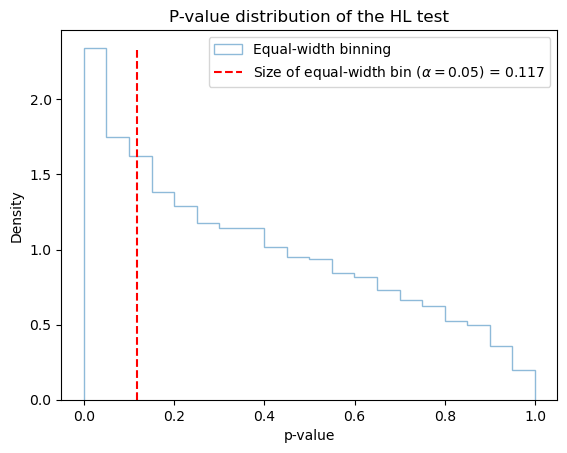

In [6]:
value,_,_=plt.hist(hl_h_pvalue, bins=20, density=True, alpha=0.5, label='Equal-width binning',histtype='step')
plt.vlines(size_h,ymin=0,ymax=np.max(value),linestyle='--',label=r'Size of equal-width bin ($\alpha=0.05$) = '+str(round(size_h,3)),colors='r')
plt.legend(loc='upper right')
plt.xlabel('p-value')
plt.ylabel('Density')
plt.title('P-value distribution of the HL test')

Text(0.5, 1.0, 'P-value distribution of the HL test')

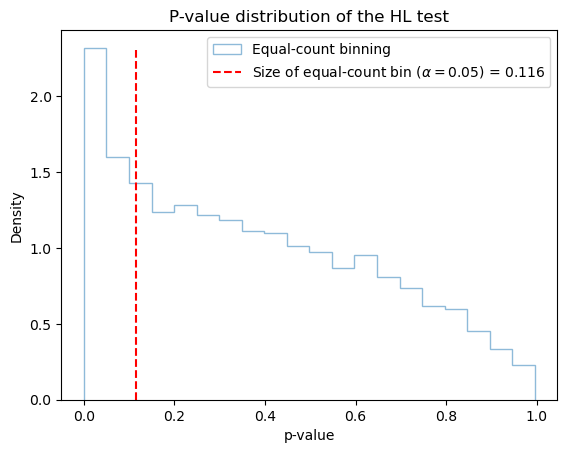

In [7]:
value,_,_=plt.hist(hl_c_pvalue, bins=20, density=True, alpha=0.5, label='Equal-count binning',histtype='step')
plt.vlines(size_c,ymin=0,ymax=np.max(value),linestyle='--',label=r'Size of equal-count bin ($\alpha=0.05$) = '+str(round(size_c,3)),colors='r')
plt.legend(loc='upper right')
plt.xlabel('p-value')
plt.ylabel('Density')
plt.title('P-value distribution of the HL test')

We can see that both the equal-width and the equal-count method have the incorrect size. The simulation support the claim that the degree of freedom should be M instead of M-2. We can show it with simulation. We are not proving the claim here since it is beyond the scope of this documentation.

In [6]:
### The size of HL Test
from calzone.utils import fake_binary_data_generator
from importlib import reload
import calzone.metrics
reload(calzone.metrics)
from calzone.metrics import CalibrationMetrics
np.random.seed(123)
fakedata_generator = fake_binary_data_generator(alpha_val=0.5, beta_val=0.5)
cal_metrics = CalibrationMetrics()
sample_size = 1000
simulation_size = 10000
results = []
# generate data
for i in range(simulation_size):
    X, y = fakedata_generator.generate_data(sample_size)
    if i == 0:
        tempresult = cal_metrics.calculate_metrics(y, X, ['HL-H', 'HL-C'],return_numpy=False, df = 10)
        keys = list(tempresult.keys())
        results.append(np.array(list(tempresult.values())))
    else:
        tempresult = cal_metrics.calculate_metrics(y, X, ['HL-H', 'HL-C'],return_numpy=True, df = 10)
        results.append(tempresult)
results = np.array(results)

hl_h_pvalue = results[:,1]
hl_c_pvalue = results[:,3]
size_h = np.mean(hl_h_pvalue < 0.05)
size_c = np.mean(hl_c_pvalue < 0.05)
print("The size of HL-H with df=M is :", round(size_h,3))
print("The size of HL-C with df=M  is :", round(size_c,3))

The size of HL-H with df=M is : 0.047
The size of HL-C with df=M  is : 0.055


## Reference

Hosmer, D. W., & Lemesbow, S. (1980). Goodness of fit tests for the multiple logistic regression model. Communications in statistics-Theory and Methods, 9(10), 1043-1069.

Hosmer, D. W., Hosmer, T., Cessie, S. L., & Lemeshow, S. (1997). A COMPARISON OF GOODNESS-OF-FIT TESTS FOR THE LOGISTIC REGRESSION MODEL. 16.
